In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [5]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [6]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

(CVXPY) Feb 26 09:37:37 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [7]:
class SamplingBias():
    def __init__(self, m, n, normalize=True):
        self.m = m
        self.n = n
        self.shape = (self.m, self.n)
        self.std = normalize
        
    def latent_weights(self, U, V, r, v, a, b, scale=0.5):
        r = int(len(v)/2)
        x = np.tile(np.dot(U, v[:r]), (len(U),1)).T + np.tile(np.dot(V, v[r:]), (len(U),1))
        w = np.zeros_like(x)
        w[np.where((x <= b) & (x >= a))] = 1
        w[np.where(x > b)] = scipy.stats.norm.pdf(x[np.where(x > b)], loc=b, scale=scale)/scipy.stats.norm.pdf(b, loc=b, scale=scale)
        w[np.where(x < a)] = scipy.stats.norm.pdf(x[np.where(x < a)], loc=a, scale=scale)/scipy.stats.norm.pdf(a, loc=a, scale=scale)
        return w/np.sum(w) if self.std else w

    def unif_weights(self):
        w = np.ones(self.shape)
        return w/np.sum(w) if self.std else w

    def inc_weights(self, scale=1):
        w = np.arange(1, self.m*self.n+1)**scale/(self.m*self.n)
        w = w.reshape(self.shape)
        return w/np.sum(w) if self.std else w

In [232]:
# Matrix shape and rank
n1, n2 = 500,500
k = 10
r = 3
prop_obs = 0.2
random_state = 0
allow_inf = False
alpha = 0.1

In [239]:
max_test_queries = 500
bias_scale = 0.8
sampler = QuerySampling(n1,n2)
bias = SamplingBias(n1,n2)

# Split observation mask and test mask
w = bias.inc_weights(scale = bias_scale)
mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, w=w, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [240]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

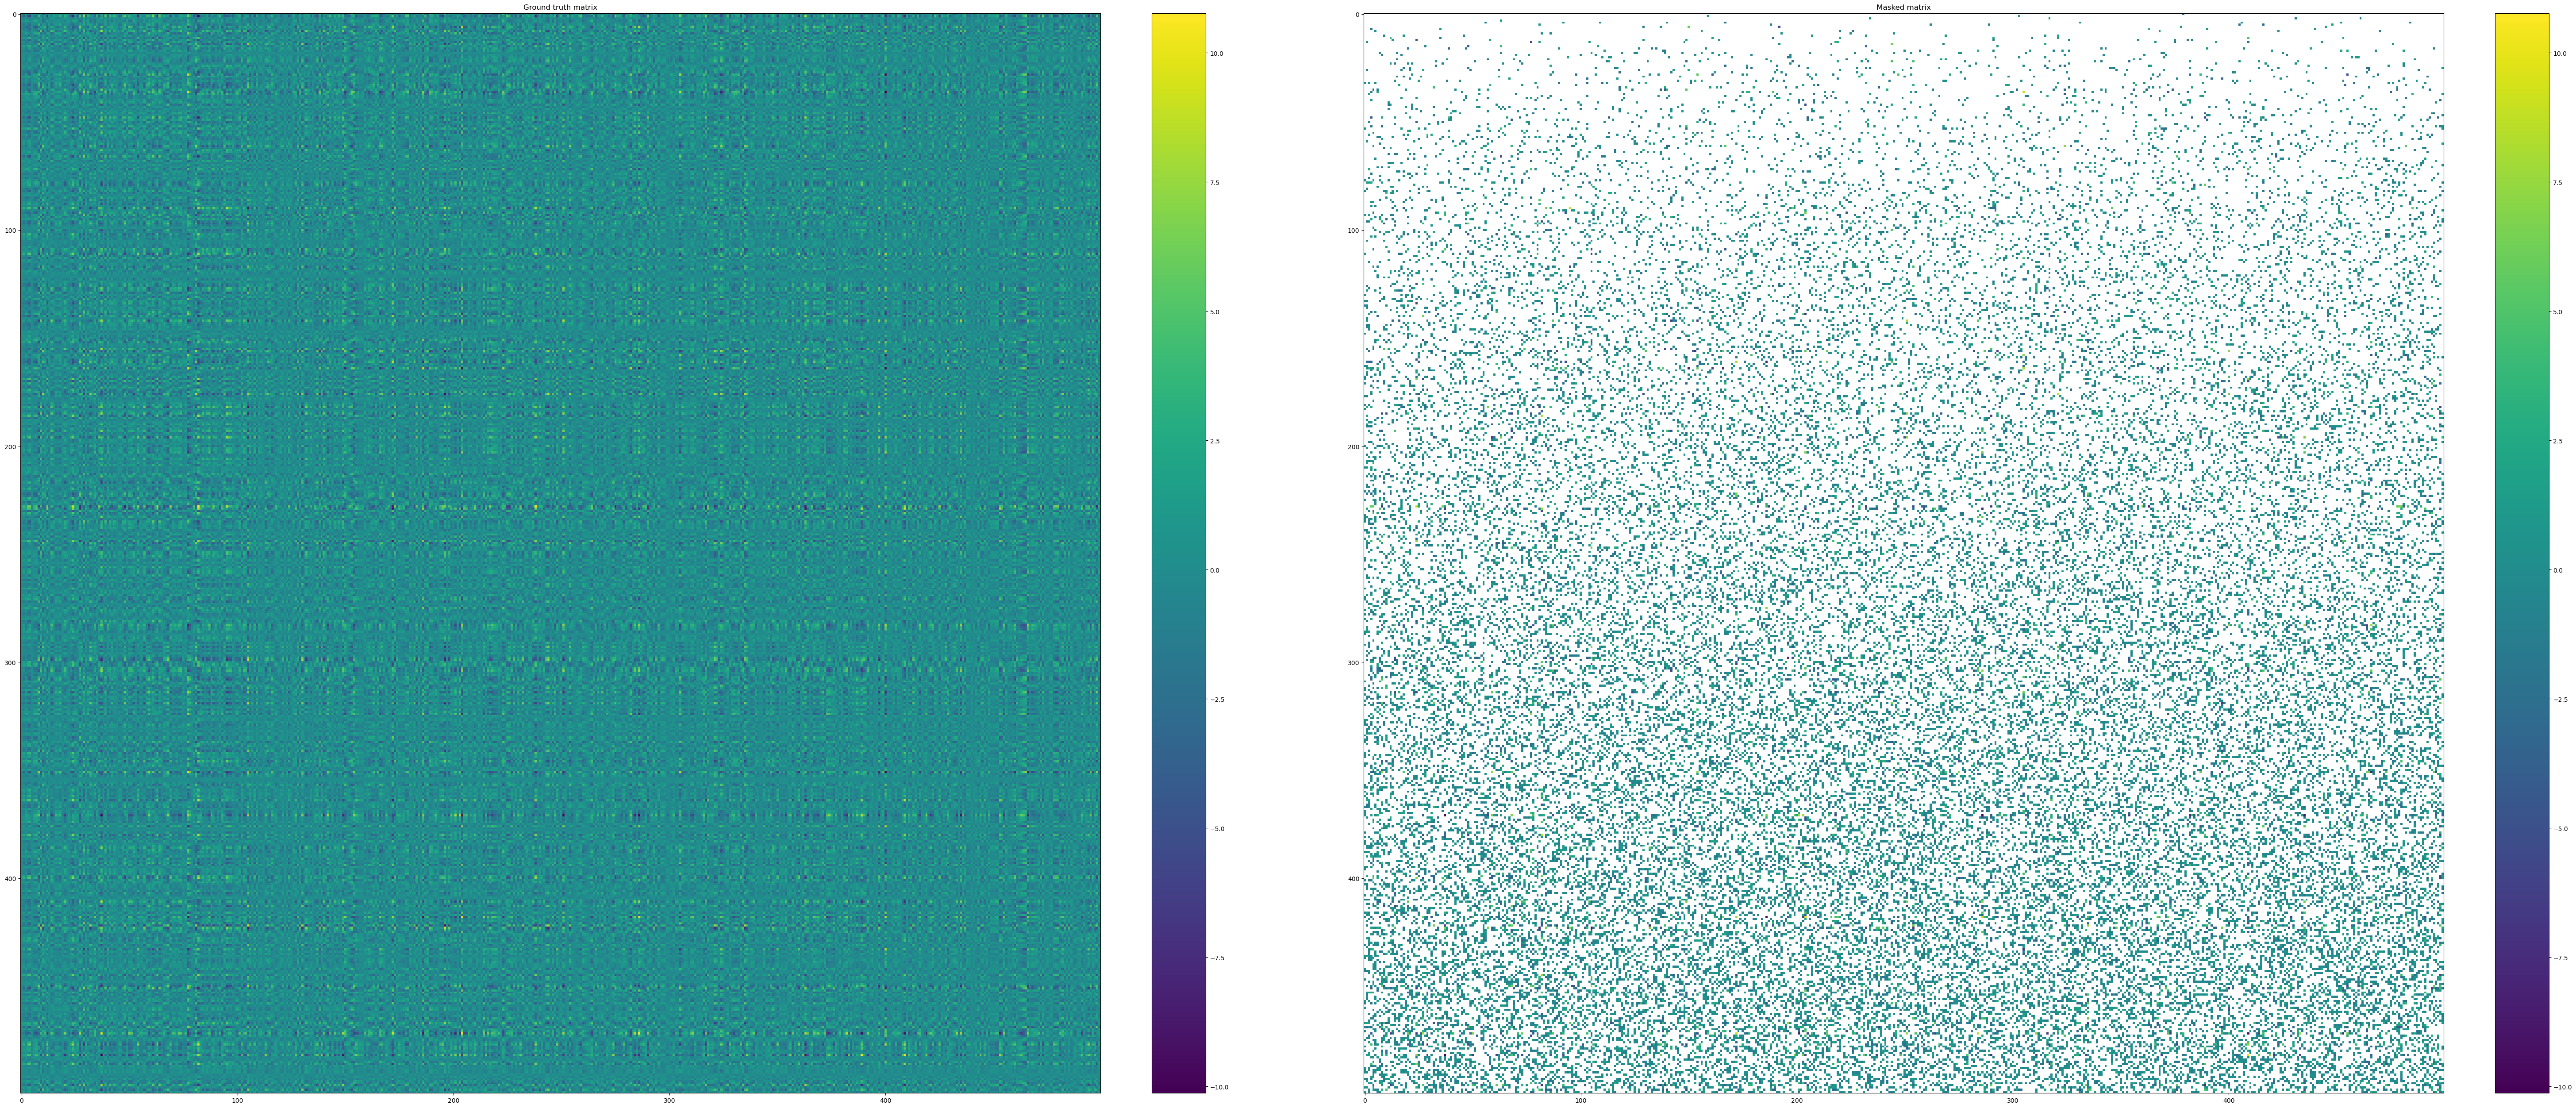

Missing entries are masked in white.


In [241]:
plot_before_after_mask(M, mask_obs, bad_color="white", figsize=(60,25))
print("Missing entries are masked in white.")

# Simultaneous Conformal Inference

In [242]:
max_calib_queries = 1000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 50000, training size: 40000,  calib queries: 1000, test queries: 500


In [243]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0004
Iteration: 2; Mean diff: 0.0000
Stopping criteria met, training terminated.


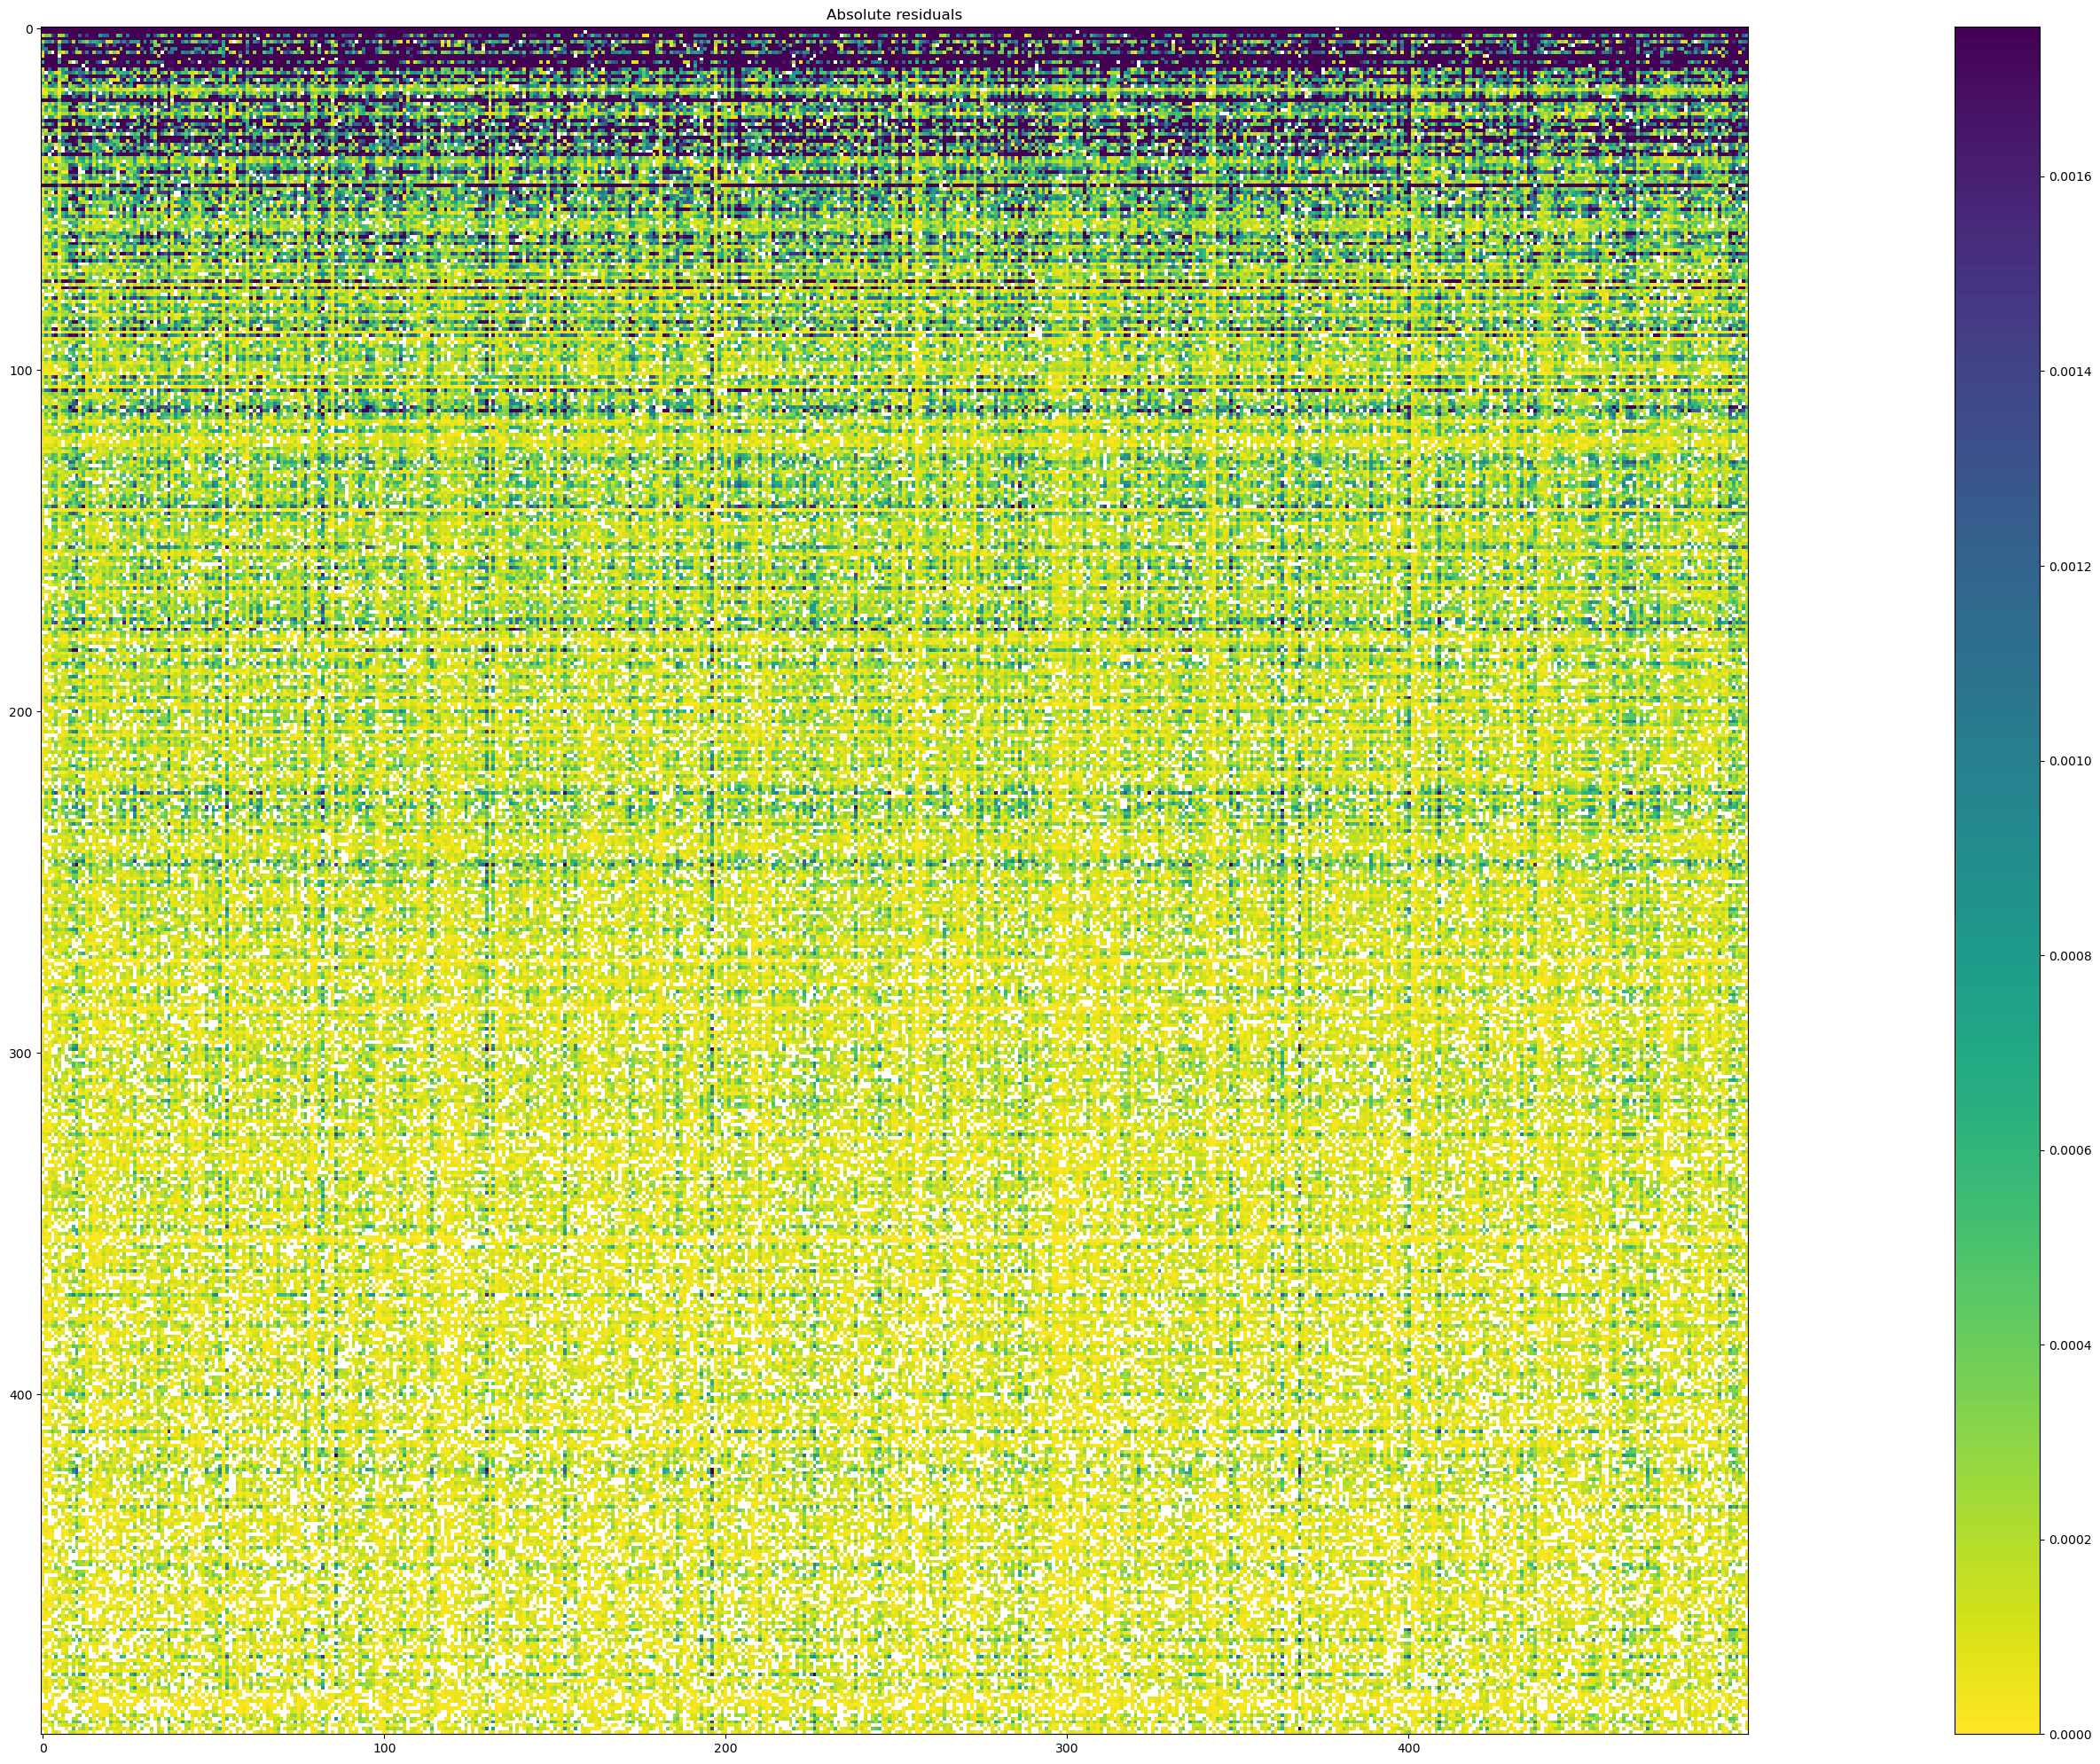

In [244]:
error_heatmap(M, Mhat, mask_test, figsize=(60,25))

In [208]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w)
df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SMC")

Computing conformal prediction intervals for 500 test queries...


CI: 100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.64it/s]

Done!


In [209]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.914,0.9692,0.28457,0.078,SMC


# Bonferroni benchmark

In [141]:
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, 1, 
                                        calib_size=n_calib_queries*k, random_state=random_state)

print("Observation size: {}, training size: {}, calib size: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), len(idxs_test[0])//k))

Observation size: 50000, training size: 45000, calib size: 5000, test queries: 500


In [142]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state)

Iteration: 1; Mean diff: 0.0005
Iteration: 2; Mean diff: 0.0000
Stopping criteria met, training terminated.


In [143]:
a_list = [alpha, alpha * k]
ci_method = Bonf_benchmark(M, Mhat, mask_obs, idxs_calib, k, w_obs=w)
df = ci_method.get_CI(idxs_test, a_list, allow_inf=allow_inf)
for i, m in enumerate(["Bonferroni", "Uncorrected"]):
    lower, upper, is_inf= df.loc[i].lower, df.loc[i].upper, df.loc[i].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method=m)])

Computing Bonferroni-style intervals for 500 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 2500/2500 [05:50<00:00,  7.14it/s]

Done!


In [144]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.902,0.9276,0.018070,0.0960,SMC
0,0.948,0.9680,0.516077,0.0368,Bonferroni
0,0.800,0.8620,0.020851,0.0148,Uncorrected


In [245]:
round(1.2,1)

1.2